What are the peculiar velocities of the Coma cluster galaxies?

In [1]:
import numpy as np

from astropy.table import Table
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u

import pickle

import matplotlib.pyplot as plt

In [2]:
h = 1
H0 = 100*h

c = 3e5

# Data

SGA catalog with computed peculiar velocities

In [3]:
SGA_TF = Table.read('SGA_fuji_jointTFR-varyV0-perpdwarf_moduli_pec.fits')
SGA_TF[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p33R26,V_0p33R26_err,R_ABSMAG_SB26,R_ABSMAG_SB26_err,R_ABSMAG_SB26_TFbright,R_ABSMAG_SB26_TFbright_err,mu_TFbright,mu_TFbright_err,V_PEC,VERR_PEC
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,km / s,
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
896,SGA-2020 896,PGC1190469,1190469,180.38184750000002,1.2958311000000002,Sc,76.42,0.44771332,0.7726806,0.022478215,23.47448,16.591,False,LEDA-20181114,256,PGC1190469,1,True,180.38184750000002,1.2958311000000002,0.44771332,1803p012,180.38182702766252,1.2958268307578154,0.6239483,SB26,76.93204,0.79918337,180.38178401011206,1.295990493861164,16.25661,7.6343946,7.3312407,7.215459,4.267071,6.71145,8.98399,11.085844,12.783826,14.283976,15.799797,17.191736,18.718449,18.022089,17.380363,16.982048,17.370085,16.760023,16.377943,16.967363,16.3918,16.024693,16.728146,16.17214,15.817478,16.609686,16.06539,15.715597,16.54587,16.008068,15.658699,16.505327,15.967604,15.619181,16.48057,15.942226,15.594475,16.459711,15.924162,15.572447,0.02403138,0.037713606,0.06752815,0.0597593,0.041663416,0.057950046,0.06897008,0.07238169,0.11818266,0.0070740557,0.008179923,0.008415725,0.005835994,0.006626628,0.0068130954,0.0056522293,0.006152283,0.0062183426,0.0057331356,0.0059468574,0.0059097866,0.005547482,0.0057424223,0.005712396,0.005370375,0.0055686547,0.005550764,0.0052407323,0.0054267743,0.0054291

In [5]:
FP = Table.read('../../SV/DESI_FP_logdists_fiducial.csv', format='ascii.commented_header')
FP[:5]

fibermap_targetid,fibermap_i,ra_1,dec_1,targetid,id,healpix,survey,program,targetid.1,z_x,zerr,zwarn,spectype,subtype,deltachi2,healpix_id,targetid.2,target_ra,target_dec,obsconditions,release,brickid_1,brick_objid,fiberflux_ivar_g,fiberflux_ivar_r,fiberflux_ivar_z,morphtype,flux_g,flux_r,flux_z,flux_ivar_g,flux_ivar_r,flux_ivar_z,ebv,flux_w1,flux_w2,flux_ivar_w1,flux_ivar_w2,fiberflux_g,fiberflux_r,fiberflux_z,fibertotflux_g,fibertotflux_r,fibertotflux_z,sersic_1,coadd_numexp,coadd_exptime,coadd_numnight,coadd_numtile,healpix_id.1,objid_1,brickid.1,brickname_1,ra.1,dec.1,ppxf_sigma,ppxf_sigma_error,DER_SNR,snr_ppxf,OBJID_2,BRICKID_2,BRICKNAME_2,RA_2,DEC_2,TYPE,SERSIC_2,Z_PHOT_MEDIAN,Z_PHOT_L95,mag_g,mag_r,mag_z,mag_B,mag_g_err,mag_r_err,mag_z_err,fibre_mag_g,fibre_mag_r,fibre_mag_z,uncor_radius,BA_ratio,circ_radius,uncor_radius_err,err_shape_e1,err_shape_e2,pos_angle,Separation,mag_r_corrected,BA_ratio_error,TargetId,tmass,flag,z_y,rmag,g_r_PS1_5_cor,W2_W3,W2_W3_err,PS1_ibumpy,zcmb,zcmb_group,dz,dz_group,r,er,kcor_r,kcor_g,i,ei,s,es,absmag_r,Sn,logdist,logdist_err,logdist_alpha,pv,pverr
int64,int64,float64,float64,int64,int64,int64,str3,str6,int64,float64,float64,int64,str6,int64,float64,int64,int64,float64,float64,int64,int64,int64,int64,str5,int64,int64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,int64,int64,int64,int64,str8,float64,float64,float64,float64,float64,float64,int64,int64,str8,float64,float64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str22,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39628417112478213,400,192.260476663904,26.8931119632851,39628417112478213,1301,28148,sv1,bright,39628417112478213,0.0246198717561043,3.05679754892841e-06,0,GALAXY,--,208858.610858595,1301,39628417112478213,192.260476663904,26.8931119632851,4,9010,481140,4613,False,--,--,SER,718.737670898438,1493.39233398438,2632.02905273438,12.3129425048828,3.62823224067688,2.14227867126465,0.0110182352364063,1792.16967773438,1005.01934814453,-1.0,-1.0,84.9578857421875,176.525405883789,311.1171875,84.9578857421875,176.525405883789,311.1171875,3.24683547019958,15,6695.12646484375,7,1,1301,4613,481140,1921p270,192.260476663904,26.8931119632851,138.97191401554343,1.3838325204676758,50.32823792570804,37.09863394208711,4613,481140,1921p270,192.26047666390429,26.89311196328508,SER,3.2468355,0.023591544,0.018623924,15.323162,14.54071,13.93593,15.744,0.00041668504,0.00037338858,0.00027839307,17.641579,16.859127,16.254347,5.18443,0.3502856,3.068401,0.001138905,0.00015687887,0.00016151024,-22.695267,9.032862052074111e-10,14.54071,0.0001115389190186,39628417112478213,2MASXJ12490248+2653350,1,0.0246,14.367,0.643,0.902,0.145,0.216,0.02556977744883837,0.02556977744883837,76.1982724818877,76.1982724818877,0.04386937487526493,0.00011782648155669783,0.02503684213839932,0.04334819959542904,2.9441341941217747,0.0002789970682498833,2.154576602686897,0.004324548825517668,-19.92513203057605,1.0,0.04082911658524023,0.10087512604970075,-0.21153047623097235,716.01186967735,1769.0264607119864
39628417133447721,426,193.57922538261,27.0680307191934,39628417133447721,1304,28149,sv1,bright,39628417133447721,0.0278119786253126,2.6882528734125e-06,0,GALAXY,--,648939.39017427,1304,39628417133447721,193.57922538261,27.0680307191934,4,9010,481145,2601,--,--,--,SER,5968.87890625,12903.7099609375,23318.6015625,1.23958659172058,0.327169686555862,0.208652123808861,0.008288275450468,16008.04296875,9302.5791015625,-1.0,-1.0,225.581344604492,487.668823242188,881.277954101562,225.581451416016,487.669097900391,881.278625488281,4.501549243927,15,6695.12646484375,

# Coma cluster membership

In [6]:
# Data table #3 from Tully (2015)
hdu = fits.open('../Tully15-Table3.fits')
table3 = Table(hdu[1].data)
hdu.close()

In [7]:
Coma_nest = 100001

Coma_row_t3 = table3['Nest'] == Coma_nest

R2t_Coma = table3['R2t'][Coma_row_t3][0]
sigma_Coma = table3['sigP'][Coma_row_t3][0]
mu_Coma = table3['DM'][Coma_row_t3][0]

Coma_coords = SkyCoord(table3['SGLON'][Coma_row_t3]*u.degree, 
                       table3['SGLAT'][Coma_row_t3]*u.degree, 
                       frame='supergalactic')

sigma_Coma

1045

In [8]:
d_Coma = 10*10**(0.2*mu_Coma) # pc
V_Coma = 100*(d_Coma*1e-6)    # km/s

## Calculate the projected distance between the Coma cluster and each galaxy

In [9]:
# First, we need to convert R2t from Mpc to an angle, using the group's velocity
# Note that we are NOT assuming that the size of the cluster is a small angle!!
R2t_Coma_angle_1p5 = np.arctan(1.5*R2t_Coma/(d_Coma*1e-6))*u.radian
R2t_Coma_angle_3 = np.arctan(3*R2t_Coma/(d_Coma*1e-6))*u.radian

In [10]:
SGA_coords = SkyCoord(SGA_TF['RA'], SGA_TF['DEC'], unit='deg')
FP_coords = SkyCoord(FP['ra_1'], FP['dec_1'], unit='deg')

sep_SGA = Coma_coords.separation(SGA_coords)
sep_FP = Coma_coords.separation(FP_coords)

In [11]:
SGA_in_Coma1 = (sep_SGA < R2t_Coma_angle_1p5) & (SGA_TF['Z_DESI']*c > V_Coma - 3*sigma_Coma) & (SGA_TF['Z_DESI']*c < V_Coma + 3*sigma_Coma)
FP_in_Coma1 = (sep_FP < R2t_Coma_angle_1p5) & (FP['z_x']*c > V_Coma - 3*sigma_Coma) & (FP['z_x']*c < V_Coma + 3*sigma_Coma)

SGA_in_Coma2 = (sep_SGA >= R2t_Coma_angle_1p5) & (sep_SGA < R2t_Coma_angle_3) & (SGA_TF['Z_DESI']*c > V_Coma - 2*sigma_Coma) & (SGA_TF['Z_DESI']*c < V_Coma + 2*sigma_Coma)
FP_in_Coma2 = (sep_FP >= R2t_Coma_angle_1p5) & (sep_FP < R2t_Coma_angle_3) & (FP['z_x']*c > V_Coma - 2*sigma_Coma) & (FP['z_x']*c < V_Coma + 2*sigma_Coma)

SGA_in_Coma = SGA_in_Coma1 | SGA_in_Coma2
FP_in_Coma = FP_in_Coma1 | FP_in_Coma2

################################################################################
# Keep all observations of each galaxy that are within the Coma cluster
#-------------------------------------------------------------------------------
SGA_ID_in_Coma = SGA_TF['SGA_ID'][SGA_in_Coma]

SGA_TF_Coma = SGA_TF[SGA_in_Coma]
FP_Coma = FP[FP_in_Coma]
################################################################################

In [12]:
SGA_TF_Coma_dict = {}

for i in range(len(SGA_TF_Coma)):
    SGA_TF_Coma_dict[SGA_TF_Coma['SGA_ID'][i]] = i

### Identify which Coma galaxies are "dwarfs"

In [13]:
temp_infile = open('cov_ab_fuji_joint_TFR_varyV0-perpdwarfs2_KAD.pickle', 'rb')
cov_ab, tfr_samples, V0 = pickle.load(temp_infile)
temp_infile.close()

In [14]:
slope = np.median(tfr_samples[0])
slope_err = np.sqrt(cov_ab[0,0])

ZP = np.median(tfr_samples[2])
ZP_err = np.sqrt(cov_ab[2,2])

In [15]:
logV_n17 = (-17 - ZP)/slope + V0
b_perp = -17 + (1/slope)*(logV_n17 - V0)

dwarf_boolean = (SGA_TF_Coma['R_ABSMAG_SB26'] - SGA_TF_Coma['R_ABSMAG_SB26_err']) > (-(np.log10(SGA_TF_Coma['V_0p33R26']) - V0)/slope + b_perp)

In [16]:
print('SGA galaxies in Coma with distance moduli:', len(SGA_ID_in_Coma))
print('non-"dwarf" SGA galaxies in Coma with distance moduli:', len(SGA_ID_in_Coma) - sum(dwarf_boolean))

SGA galaxies in Coma with distance moduli: 104
non-"dwarf" SGA galaxies in Coma with distance moduli: 99


# Plots

In [17]:
# Define the velocity histogram bins so that they are centered around the cluster's redshift
bin_width = 1500 # km/s
v_min = -41000
v_max = 41000

v_bins = np.arange(v_min, v_max, bin_width)

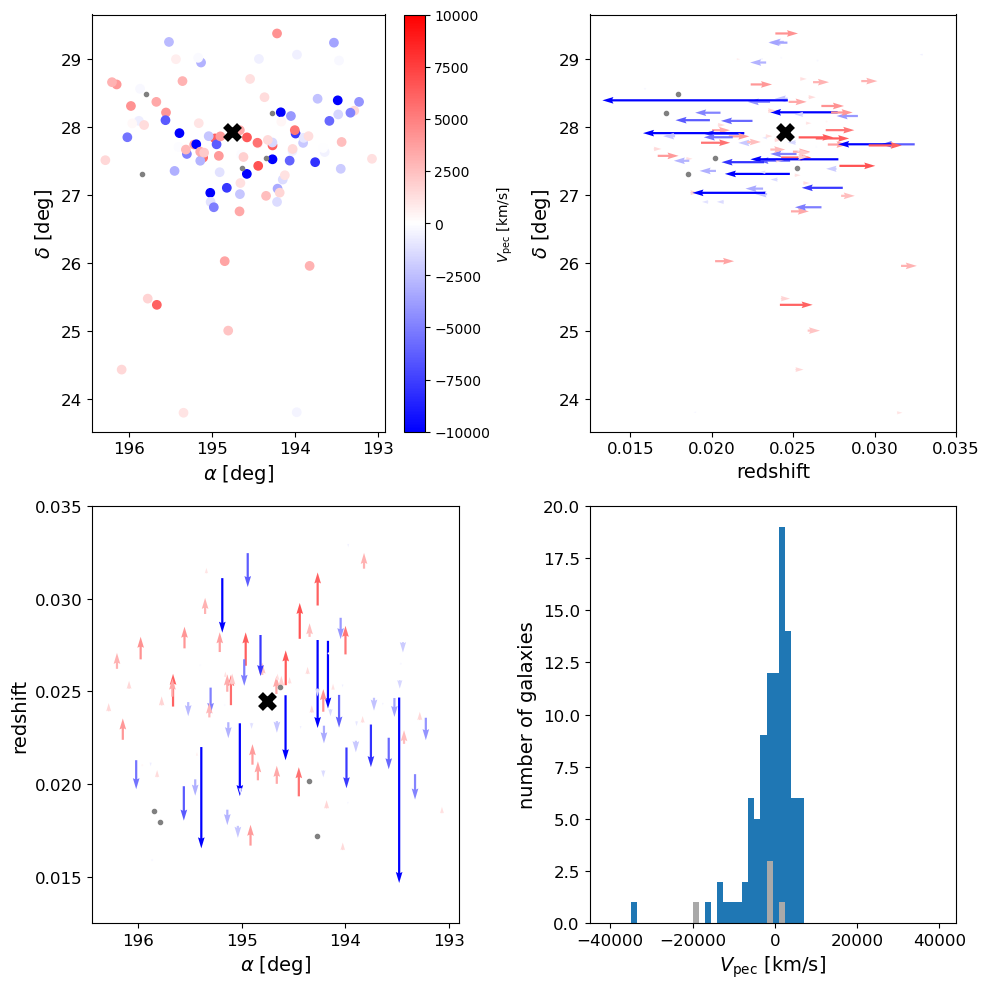

In [18]:
plt.figure(figsize=(10, 10), tight_layout=True)

plt.subplot(221)
plt.scatter(SGA_TF_Coma['RA'][~dwarf_boolean], SGA_TF_Coma['DEC'][~dwarf_boolean], c=SGA_TF_Coma['V_PEC'][~dwarf_boolean], marker='o', cmap='bwr', vmin=-10000, vmax=10000)
plt.plot(SGA_TF_Coma['RA'][dwarf_boolean], SGA_TF_Coma['DEC'][dwarf_boolean], '.', c='gray')
plt.plot(Coma_coords.transform_to('icrs').ra.deg, Coma_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.gca().invert_xaxis()
plt.xlabel(r'$\alpha$ [deg]', fontsize=14)
plt.ylabel(r'$\delta$ [deg]', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.colorbar(label=r'$V_\text{pec}$ [km/s]')

plt.subplot(222)
# plt.plot(SGA_TF_Coma['Z_DESI'][~dwarf_boolean], SGA_TF_Coma['DEC'][~dwarf_boolean], 'o', alpha=0.5)
plt.quiver(SGA_TF_Coma['Z_DESI'][~dwarf_boolean], SGA_TF_Coma['DEC'][~dwarf_boolean], 
           SGA_TF_Coma['V_PEC'][~dwarf_boolean]/c, 
           np.zeros(np.sum(~dwarf_boolean)), 
           SGA_TF_Coma['V_PEC'][~dwarf_boolean], 
           angles='xy', 
           cmap='bwr')
plt.clim(-10000, 10000)
plt.plot(SGA_TF_Coma['Z_DESI'][dwarf_boolean], SGA_TF_Coma['DEC'][dwarf_boolean], '.', c='gray')
plt.plot(V_Coma/c, Coma_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlim((0.0125, 0.035))
plt.xlabel('redshift', fontsize=14)
plt.ylabel(r'$\delta$ [deg]', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(223)
plt.quiver(SGA_TF_Coma['RA'][~dwarf_boolean], SGA_TF_Coma['Z_DESI'][~dwarf_boolean], 
           np.zeros(np.sum(~dwarf_boolean)), 
           SGA_TF_Coma['V_PEC'][~dwarf_boolean]/c, 
           SGA_TF_Coma['V_PEC'][~dwarf_boolean], 
           angles='xy', 
           cmap='bwr')
plt.clim(-10000, 10000)
plt.plot(SGA_TF_Coma['RA'][dwarf_boolean], SGA_TF_Coma['Z_DESI'][dwarf_boolean], '.', c='gray')
plt.plot(Coma_coords.transform_to('icrs').ra.deg, V_Coma/c, 'kx', ms=10, mew=5)
plt.gca().invert_xaxis()
plt.ylim((0.0125, 0.035))
plt.ylabel('redshift', fontsize=14)
plt.xlabel(r'$\alpha$ [deg]', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(224)
plt.hist(SGA_TF_Coma['V_PEC'][~dwarf_boolean], bins=v_bins)
plt.hist(SGA_TF_Coma['V_PEC'][dwarf_boolean], bins=v_bins, color='darkgray')
plt.xlabel(r'$V_\text{pec}$ [km/s]', fontsize=14)
plt.ylabel('number of galaxies', fontsize=14)
plt.ylim(ymax=20)
plt.tick_params(axis='both', which='major', labelsize=12);

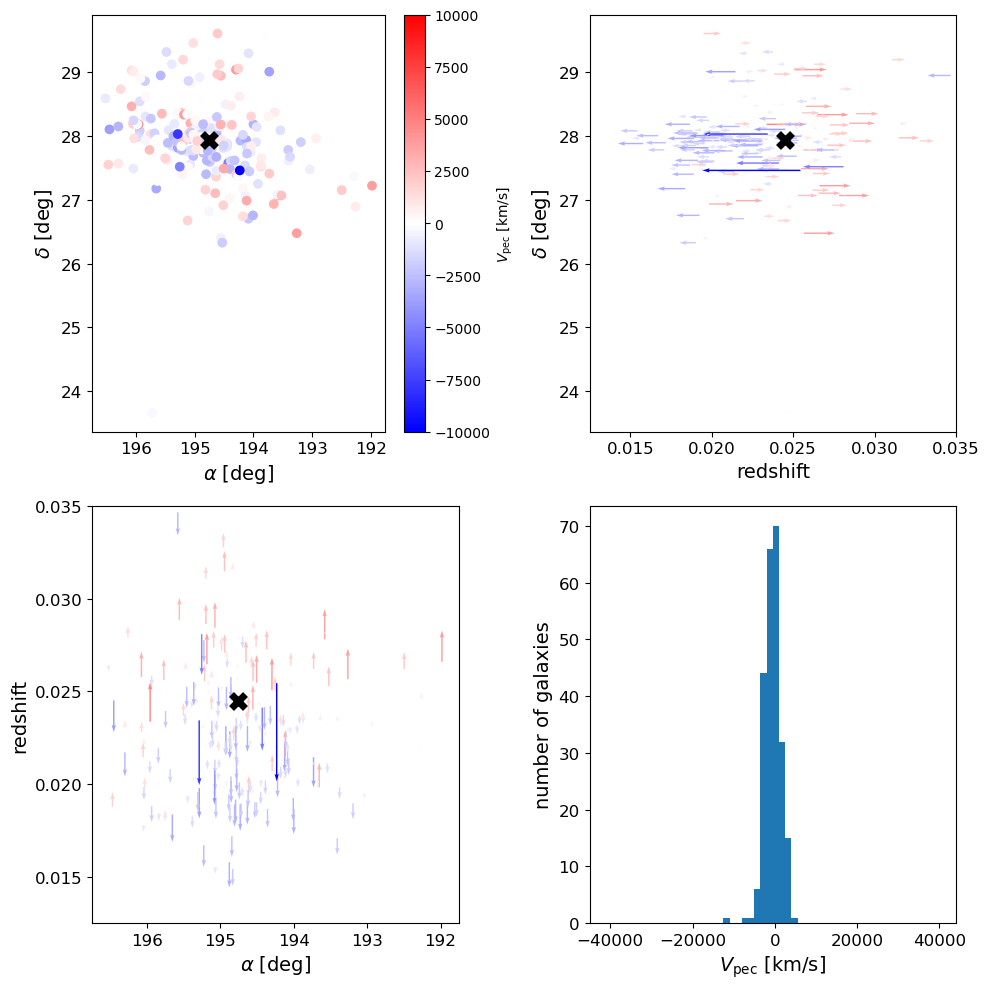

In [19]:
plt.figure(figsize=(10, 10), tight_layout=True)

plt.subplot(221)
plt.scatter(FP_Coma['ra_1'], FP_Coma['dec_1'], c=FP_Coma['pv'], marker='o', cmap='bwr', vmin=-10000, vmax=10000)
plt.plot(Coma_coords.transform_to('icrs').ra.deg, Coma_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.gca().invert_xaxis()
plt.xlabel(r'$\alpha$ [deg]', fontsize=14)
plt.ylabel(r'$\delta$ [deg]', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.colorbar(label=r'$V_\text{pec}$ [km/s]')

plt.subplot(222)
plt.quiver(FP_Coma['z_x'], FP_Coma['dec_1'], 
           FP_Coma['pv']/c, 
           np.zeros(len(FP_Coma)), 
           FP_Coma['pv'], 
           angles='xy', 
           cmap='bwr')
plt.clim(-10000, 10000)
plt.plot(V_Coma/c, Coma_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlim((0.0125, 0.035))
plt.xlabel('redshift', fontsize=14)
plt.ylabel(r'$\delta$ [deg]', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(223)
plt.quiver(FP_Coma['ra_1'], FP_Coma['z_x'], 
           np.zeros(len(FP_Coma)), 
           FP_Coma['pv']/c, 
           FP_Coma['pv'], 
           angles='xy', 
           cmap='bwr')
plt.clim(-10000, 10000)
plt.plot(Coma_coords.transform_to('icrs').ra.deg, V_Coma/c, 'kx', ms=10, mew=5)
plt.gca().invert_xaxis()
plt.ylim((0.0125, 0.035))
plt.ylabel('redshift', fontsize=14)
plt.xlabel(r'$\alpha$ [deg]', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(224)
plt.hist(FP_Coma['pv'], bins=v_bins)
plt.xlabel(r'$V_\text{pec}$ [km/s]', fontsize=14)
plt.ylabel('number of galaxies', fontsize=14)
# plt.ylim(ymax=20)
plt.tick_params(axis='both', which='major', labelsize=12);

In [78]:
SGA_TF_Coma[['RA', 'DEC', 'R_ABSMAG_SB26', 'R_ABSMAG_SB26_TFbright', 'Z_DESI', 'V_PEC']][~dwarf_boolean]

RA,DEC,R_ABSMAG_SB26,R_ABSMAG_SB26_TFbright,Z_DESI,V_PEC
,,,,,km / s
float64,float64,float64,float64,float64,float64
195.5175248072576,29.25343316744243,-21.212435144755226,-21.883218668376212,0.024424783180508204,-2657.131780889513
195.8801475000072,28.092292037517755,-18.259347089772056,-18.481271747718434,0.0211655216585879,-687.6479107668092
195.97667146704435,28.31062379047577,-17.606822475770528,-15.961331556722973,0.0267297616862906,4254.849775579919
194.20691376173056,27.093895925073287,-19.83257552245631,-20.679296184848692,0.023151851548002977,-3316.976037893848
194.44232872174598,27.757041719948074,-19.313943772564393,-19.117163998586765,0.020498886671880285,528.5260765422308
195.77392314727763,25.474983294358566,-18.36767859940356,-17.780561652379294,0.02424307802433,1717.9859874449812
194.91584295024506,27.57659701336176,-17.872730071470336,-14.53843882123089,0.0166860235629284,3924.3512255486608
195.1049410722678,27.552245228704873,-18.067553195229856,-14.762431095165462,0.0242599032137511,5684.440845456947


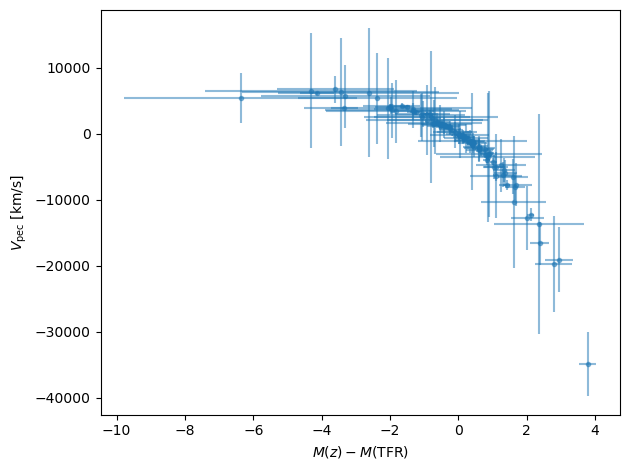

In [91]:
plt.figure(tight_layout=True)

plt.errorbar(SGA_TF_Coma['R_ABSMAG_SB26'] - SGA_TF_Coma['R_ABSMAG_SB26_TFbright'], SGA_TF_Coma['V_PEC'], 
             xerr=SGA_TF_Coma['R_ABSMAG_SB26_TFbright_err'], 
             yerr=SGA_TF_Coma['VERR_PEC'], 
             fmt='.', 
             alpha=0.5)

# plt.yscale('log')

plt.xlabel(r'$M(z) - M(\text{TFR})$')
plt.ylabel(r'$V_\text{pec}$ [km/s]');

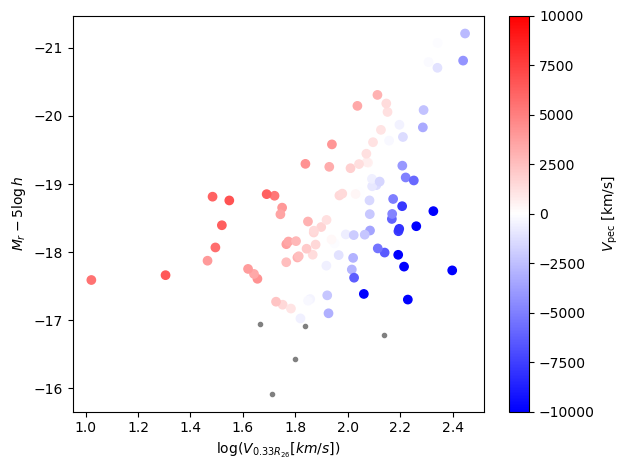

In [88]:
plt.figure(tight_layout=True)

plt.scatter(np.log10(SGA_TF_Coma['V_0p33R26'][~dwarf_boolean]), SGA_TF_Coma['R_ABSMAG_SB26'][~dwarf_boolean], c=SGA_TF_Coma['V_PEC'][~dwarf_boolean], cmap='bwr', vmin=-10000, vmax=10000)
plt.plot(np.log10(SGA_TF_Coma['V_0p33R26'][dwarf_boolean]), SGA_TF_Coma['R_ABSMAG_SB26'][dwarf_boolean], '.', c='gray')

plt.gca().invert_yaxis()

plt.colorbar(label=r'$V_\text{pec}$ [km/s]')

plt.xlabel('$\log (V_{0.33R_{26}} [km/s])$')
plt.ylabel('$M_r - 5\log h$');